In [1]:
from pylab import *
from sympy import *
from sympy.solvers import solve
import numpy as np 
import transforms3d as tf3d
from collections import OrderedDict

init_printing()

# Initialisation des fonctions lambdifier pour la simulation
## Lambdification des calculs de Cd et Cl

In [2]:
##################################################### Calcul de l'angle d'attaque et calcul du coefficient sigma qui donne la transition entre le modèle flate plate te small angle #################################
def compute_alpha_sigma(dragDirection, liftDirection, frontward_Body, VelinLDPlane, alpha_0, alpha_s, delta_s): 
    calpha= np.vdot(dragDirection, frontward_Body)
    absalpha= -np.arccos(calpha)
    signalpha = np.sign(np.vdot(liftDirection, frontward_Body)) 
    if np.linalg.norm(VelinLDPlane)>1e-7 :
        alpha = signalpha*absalpha 
    else :
        alpha=0
    if abs(alpha)>0.5*np.pi:
        if alpha>0 :alpha=alpha-np.pi 
        else: alpha=alpha+np.pi
    if alpha>=alpha_s+delta_s-alpha_0:
         sigma=0.0
    elif alpha>=alpha_s-alpha_0:
         sigma=0.5*(1.0+np.cos(np.pi*(alpha+alpha_0-alpha_s)/delta_s))
    elif alpha>=-alpha_s-alpha_0:
         sigma=1.0
    elif alpha>=-alpha_s-delta_s-alpha_0:
         sigma=0.5*(1.0+np.cos(np.pi*(alpha+alpha_0+alpha_s)/delta_s))
    else:
         sigma=0.0
    return alpha, sigma

def compute_alpha(dragDirection, liftDirection, frontward_Body, VelinLDPlane):
    calpha= np.vdot(dragDirection, frontward_Body)
    absalpha= -np.arccos(calpha)
    signalpha = np.sign(np.vdot(liftDirection, frontward_Body)) 
    if np.linalg.norm(VelinLDPlane)>1e-7 :
        alpha = signalpha*absalpha 
    else :
        alpha=0
    if abs(alpha)>0.5*np.pi:
        if alpha>0 :alpha=alpha-np.pi 
        else: alpha=alpha+np.pi         
    return alpha
                  
def compute_grad_sigma(alpha, alpha_0, alpha_s, delta_s, jac): 
    if alpha>=alpha_s+delta_s-alpha_0:
        sigma_alpha_s=0.0
        sigma_delta_s=0.0
    elif alpha>=alpha_s-alpha_0:
        for keys in jac:
            if keys=='alpha_stall':
                sigma_alpha_s = (0.5*np.pi  *np.sin(np.pi*(alpha + alpha_0 - alpha_s)/delta_s)) / delta_s
            elif keys=='largeur_stall':
                sigma_delta_s = (0.5*np.pi*(alpha + alpha_0 - alpha_s) * np.sin(np.pi*(alpha + alpha_0 - alpha_s)/delta_s)) / delta_s**2
            else : 
                print(" error jac keys error ")
    elif alpha>=-alpha_s-alpha_0:
        sigma_alpha_s=0.0
        sigma_delta_s=0.0
    elif alpha>=-alpha_s-delta_s-alpha_0:
        for keys in jac:
            if keys=='alpha_stall':
                    sigma_alpha_s = -(0.5*np.pi  *np.sin(np.pi*(alpha + alpha_0 + alpha_s)/delta_s)) / delta_s
            elif keys=='largeur_stall':
                    sigma_delta_s = (0.5*np.pi*(alpha + alpha_0 + alpha_s) * np.sin(np.pi*(alpha + alpha_0 + alpha_s)/delta_s)) / delta_s**2
            else : 
                print(" error jac keys error ")
    else:
        sigma_alpha_s=0.0
        sigma_delta_s=0.0
    return sigma_alpha_s, sigma_delta_s

    
# Initialisation des paramètres pour les équations symbolique
CL_1_sa = Symbol('C^{sa}_{L,1}',real=True)             # Coeff rechercher

CLsa = Symbol('C_L^{sa}',real=True)
CLfp = Symbol('C_L^{fp}',real=True)
C_L = Symbol('C_L',real=True)

CD_0_sa = Symbol('C^{sa}_{D,0}',real=True)             # Coeff rechercher
CD_1_sa = Symbol('C^{sa}_{D,1}',real=True)             # Coeff rechercher
CD_0_fp = Symbol('C^{fp}_{D,0}',real=True)             # Coeff rechercher
CD_1_fp = Symbol('C^{fp}_{D,1}',real=True)             # Coeff rechercher

CDsa = Symbol('C_D^{sa}',real=True)
CLfp = Symbol('C_L^{fp}',real=True)
C_D = Symbol('C_D',real=True)                       

k_0 = Symbol('k_0', real=True)                         # coeff rechercher
k_1 = Symbol('k_1', real=True)                         # coeff rechercher
k_2 = Symbol('k_2', real=True)                         # coeff rechercher

sigma = Symbol('sigma',real=True)                     # Coef de transistion small angle / flat plate

delta_0 = Symbol('delta_0',real=True)                 # Angle des ailerons
delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

alpha_0 = Symbol('alpha_0',real=True)                 # Coeff rechercher 
alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher
alpha = Symbol('alpha',real=True)                     # angle d'attaque
ct = Symbol('c_t', real=True)

############# Vecteur d'état pour la génération des équations pour le calcul du gradient ##############

theta_alea={  'cd1sa': CD_1_sa,
              'cl1sa':CL_1_sa,
              'cd0sa':CD_0_sa,
              'coeff_drag_shift':k_0,
              'coeff_lift_shift':k_1,
              'coeff_lift_gain':k_2}
theta_list=[]
for keys in theta_alea.keys():
    theta_list.append(keys)

theta = OrderedDict(sorted(theta_alea.items(), key=lambda t: t[0]))
##################################################### génération des équations pour Cd et Cl (utiliser pour générer les équations symbolique pour chaque surface portantes) ####################################################
def compute_cl_cd(alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa):

    CL_sa = 1/2 * CL_1_sa * sin(2*(alpha + k_1*delta_0 + alpha_0))
    CD_sa = CD_0_sa + CD_1_sa * sin(alpha + k_0*delta_0 + alpha_0)*sin(alpha +  k_0*delta_0 + alpha_0)

    CL_fp = 1/2 * CD_1_fp * sin(2*(alpha+ k_1*delta_0 + alpha_0))
    CD_fp = CD_0_fp + CD_1_fp * sin(alpha + k_0*delta_0 + alpha_0)*sin(alpha +  k_0*delta_0 + alpha_0)

    p=5
    sigma = 1.0 - ((alpha+alpha_0)**2/alpha_s**2)**p/(((alpha+alpha_0)**2/alpha_s**2)**p + 100+200*delta_s)

    C_L = CL_fp + sigma*(CL_sa - CL_fp) + k_2 * sin(delta_0)
    C_D = CD_fp + sigma*(CD_sa - CD_fp)
    return C_L, C_D

    
C_L, C_D = compute_cl_cd(alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa)
Coeff = [C_L, C_D]

grad_C_L = Matrix([C_L]).jacobian([i for i in theta.values()])
grad_C_D = Matrix([C_D]).jacobian([i for i in theta.values()])

#################################################### Lambdification des fonctions que nous allons utiliser en simulation. ####################################################
CL_function = lambdify((alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_1, k_2), C_L)          
CD_function = lambdify((alpha, alpha_0, alpha_s, delta_s, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), C_D)

##################################################### Lamdification de la fonction comprenant les deux coefficients aérodynamique, retourne sous la forme [Cl, Cd] ###################################
Coeff_function = lambdify((alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), Coeff) 

grad_Cl_function = lambdify((alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), grad_C_L)
grad_Cd_function = lambdify((alpha, alpha_0, alpha_s, delta_0, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), grad_C_D)

## Fonction utiles pour les caluls des efforts aérodynamiques des ailes et des moteurs ainsi que le calcul du gradient : 

In [3]:
################################################### Paramètres pour les équations symboliques pour les efforts aérodynamiques des ailes et des moteurs #######################

B_B       = Matrix([[1,0,0], [0,1,0], [0,0,1]])                              # Base dans le repère body

omega1, omega2, omega3 = symbols('\omega_1, \omega_2, \omega_3', real=True)
Omega     = Matrix([omega1, omega2, omega3])                                 # Vecteur de rotation
 
m = Symbol('m', real=True)    
alpha = Symbol('alpha',real=True)                     # angle d'attaque

r00, r01, r02, r10, r11, r12, r20, r21, r22 = symbols('r_{00}, r_{01}, r_{02}, r_{10}, r_{11}, r_{12}, r_{20}, r_{21}, r_{22}', real=True)
R         = Matrix([[r00,r01,r02], [r10,r11, r12], [r20, r21, r22]])          # Matrice de rotation

Vb1,Vb2,Vb3=symbols('V_{b1} V_{b2} V_{b3}',real=True)
v_B        = Matrix([Vb1, Vb2, Vb3])                                          # Vitesse du corps (repère drone)

Vw1,Vw2,Vw3=symbols('V_{w1} V_{w2} V_{w3}',real=True)                         # Vitesse du vent dans le repère NED 
v_W        = Matrix([Vw1, Vw2, Vw3])

xcp, ycp, zcp = symbols('x_{cp}, y_{cp}, z_{cp}')
X_cp     = Matrix([xcp, ycp, zcp])                                            # Position du centre de poussé d'un corps dans le repère body
alpha_0 = Symbol('alpha_0',real=True)                   # Coeff rechercher                                        

alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher
sigma = Symbol('sigma',real=True)                     # Coef de transistion small angle / flat plate

delta_0 = Symbol('delta_0',real=True)                 # Angle des ailerons
delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

A         = Symbol('A', real=True)                                            # 0.5 * rho * S 

VxNED, VyNED , VzNED = symbols('V_{NED_x} V_{NED_y} V_{NED_z}') 
Air_speed_earth  = Matrix([VxNED, VyNED , VzNED])                             # air speed dans le repère NED

VxBody, VyBody, VzBody = symbols('V_{body_x} V_{body_y} V_{body_z}') 
Air_speed_body   = Matrix([VxBody, VyBody, VzBody])                           # air speed dans le repère body

omega,ct=symbols('\omega,C_t',real=True)                                      # vitesse de rotation des moteurs, et coefficient de poussé des helices
Cd, Cl, Ct, Cq=symbols('C_d,C_l,C_t,C_q',real=True)                           # vitesse de rotation des moteurs, et coefficient de poussé des helices

cl1, cl2, cl3, cl4, cl5 = symbols('cl_1, cl_2, cl_3, cl_4, cl_5', real=True)
cd1, cd2, cd3, cd4, cd5 = symbols('cd_1, cd_2, cd_3, cd_4, cd_5', real=True)

motor_axis_in_body_frame = Matrix([1,0,0])                                    # Axe des moteurs, ici placé en mode avion

ch = Symbol('c_h')

omega_rotor = symbols('\omega_{rotor}', real=True)                            # Vitesse de rotation des moteurs
spinning_sense = symbols('\epsilon_{spin}', int=True)                         # Sens de rotation d'un moteur [-1 ou 1]

frontward_B = B_B[:,0]
upward_B    = B_B[:,2]
crossward_B = B_B[:,1]

c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)

########################################### Les différentes fonctions utilisé pour générer les différentes équations symboliques ###################################################

def GenDirectForceWing(Omega, cp, vB, vW, R, crossward_Body):
    # Cette fonction permet d'obtenir les directions des efforts de portances et de trainé en fonction des vitesses, et de l'orientation dans le repère NED.
    Air_speed_earth = vB - vW 
    Air_speed_body  = (R.T* Air_speed_earth) - cp.cross(Omega)
    VelinLDPlane    = Air_speed_body - Air_speed_body.dot(crossward_Body.T) * crossward_Body
    
    dragDirection = -VelinLDPlane / VelinLDPlane.norm()  #if VelinLDPlane_norm > VelLim else Matrix([0,0,0])
    liftDirection = -crossward_Body.cross(dragDirection) #if crossward_NED.norm() > VelLim else Matrix([0,0,0])

    return VelinLDPlane, dragDirection, liftDirection

def GenForceWing(A, VelinLDPlane, dragDirection, liftDirection, Cd, Cl, cp):
    # Cette fonction permet de générer les forces aerodynamique d'une aile dans son repère.
    D = A * VelinLDPlane.norm()**2 * dragDirection * Cd
    L = A * VelinLDPlane.norm()**2 * liftDirection * Cl

    F_wing = L+D 
    Torque_wing =  cp.cross(F_wing)

    return F_wing, Torque_wing

def Generate_grad_Force_wing(A, VelinLDPlane, dragDirection, liftDirection, Cd_grad, Cl_grad, cp):
    D = A * VelinLDPlane.norm()**2 * dragDirection * Cd_grad.T
    L = A * VelinLDPlane.norm()**2 * liftDirection * Cl_grad.T

    grad_Force_Wing = L+D 
    grad_Torque_Wing=Matrix([])
    for col in range(max(Cd_grad.shape)):
        grad_Torque_Wing = grad_Torque_Wing.col_insert(col, cp.cross(grad_Force_Wing.col(col)))    
    
    return grad_Force_Wing, grad_Torque_Wing

def Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, vB, vW,  Cd_list, Cl_list, crossward_body, r_queue, r_queue_neg):
    # Cette function permet de généer l'équation complète de la somme des forces pour les différentes surfaces portantes 
    p = 0
    Sum_Force_Wing = Matrix([0,0,0])
    Sum_Torque_Wing =  Matrix([0,0,0])
    for i in cp_list:
        VelinLDPlane, dragDirection, liftDirection= GenDirectForceWing(Omega, i, vB, vW, R_list[p], crossward_body)
        if p == 2 :
            # Comme la fonction GenForceWing donne les efforts des ailes dans leur repère propre, on doit passer par les matrice de rotation pour les ailes de la queue
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], Matrix([0,0,0]))
            Sum_Force_Wing  = Sum_Force_Wing +  r_queue.T  @ F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + i.cross(r_queue.T  @ F_wing)
        elif p == 3 :
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], Matrix([0,0,0]))
            Sum_Force_Wing  = Sum_Force_Wing +  r_queue_neg.T  @ F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + i.cross(r_queue_neg.T  @ F_wing)
        else:
            F_wing, Torque_wing =  GenForceWing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Cd_list[p], Cl_list[p], i)
            Sum_Force_Wing  = Sum_Force_Wing +  F_wing
            Sum_Torque_Wing = Sum_Torque_Wing + Torque_wing
        p+=1

    return Sum_Force_Wing, Sum_Torque_Wing

def Generate_Gradien_Sum_Force_wing(theta, A_list, Omega, cp_list, R_list, vB, vW,  Grad_Cd_list, Grad_Cl_list, crossward_body, r_queue, r_queue_neg):
    # Cette function permet de généer l'équation complète de la somme des forces pour les différentes surfaces portantes 
    p = 0
    Grad_Sum_Force_Wing = np.zeros((3,(len(theta))))
    Grad_Sum_Torque_Wing =  np.zeros((3,(len(theta))))
    for i in cp_list:
        VelinLDPlane, dragDirection, liftDirection= GenDirectForceWing(Omega, i, vB, vW, R_list[p], crossward_body)
        if p == 2 :
            # Comme la fonction GenForceWing donne les efforts des ailes dans leur repère propre, on doit passer par les matrice de rotation pour les ailes de la queue
            Grad_F_wing, Grad_T_wing =  Generate_grad_Force_wing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Grad_Cd_list[p], Grad_Cl_list[p], Matrix([0,0,0]))
            Grad_Force_wing = Grad_F_wing *0
            Grad_Torque_wing = Grad_T_wing *0
            for q in range(max(np.shape(Grad_F_wing))):
                Grad_Force_wing[:,q] = r_queue.T  @ Grad_F_wing[:,q]
                Grad_Torque_wing[:,q] = r_queue.T  @ i.cross(r_queue.T  @ Grad_F_wing[:,q])
            Grad_Sum_Force_Wing  = Grad_Sum_Force_Wing +  Grad_Force_wing
            Grad_Sum_Torque_Wing = Grad_Sum_Torque_Wing + Grad_Torque_wing
        elif p == 3 :
            Grad_F_wing, Grad_T_wing =  Generate_grad_Force_wing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Grad_Cd_list[p], Grad_Cl_list[p], Matrix([0,0,0]))
            Grad_Force_wing = Grad_F_wing *0
            Grad_Torque_wing = Grad_T_wing *0
            for q in range(max(np.shape(Grad_F_wing))):
                Grad_Force_wing[:,q] = r_queue_neg.T  @ Grad_F_wing[:,q]
                Grad_Torque_wing[:,q] = r_queue_neg.T  @ i.cross(r_queue_neg.T  @ Grad_F_wing[:,q])
            Grad_Sum_Force_Wing  = Grad_Sum_Force_Wing + Grad_Force_wing
            Grad_Sum_Torque_Wing = Grad_Sum_Torque_Wing + Grad_Torque_wing
        else:
            Grad_F_wing, Grad_T_wing =  Generate_grad_Force_wing(A_list[p], VelinLDPlane, dragDirection, liftDirection, Grad_Cd_list[p], Grad_Cl_list[p], i)
            Grad_Sum_Force_Wing  = Grad_Sum_Force_Wing +  Grad_F_wing
            Grad_Sum_Torque_Wing = Grad_Sum_Torque_Wing  + Grad_T_wing
        p+=1

    return Grad_Sum_Force_Wing, Grad_Sum_Torque_Wing


def GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame, spinning_sense):
    ## Cette fonction calcule les effort produit par un rotor sur le drone en fonction de son sens de rotation et de sa localisation, les efforts sont donnés
    ## dans le repère inertiel. l'axe des moteur est placé suivant l'axe x du drone (mode avion seulement)
    Air_speed_earth = vB - vW
    air_speed_in_rotor_frame = (R.T* Air_speed_earth) - cp.cross(Omega)
    Axial_speed = air_speed_in_rotor_frame.dot(motor_axis_in_body_frame)
    lat_speed = air_speed_in_rotor_frame - (Axial_speed * (motor_axis_in_body_frame))
        
    T = ct*omega_rotor**2
    H = ch * omega_rotor
    
    T_vec = T * motor_axis_in_body_frame - H * lat_speed
    
    torque = - omega_rotor * cq * lat_speed
    torque = - spinning_sense * cq * T * motor_axis_in_body_frame 
    torque_at_body_center = torque + cp.cross(T_vec.T)
        
    return T_vec, torque_at_body_center

def Generate_Sum_Force_Moteur(Omega, ct, cq, omega_rotor, cp_list, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list):
    # Calcul des forces des moteurs sur le drone, génère toutes les forces, ainsi que le couple appliqué au centre de gravité du drone, dans le repère inertiel
    p = 0
    Sum_Force_Rotor = Matrix([0,0,0])
    Sum_Torque_Rotor =  Matrix([0,0,0])
    for cp in cp_list:
        F_rotor, Q_rotor = GenForceMoteur(Omega, ct, cq, omega_rotor, cp, vB, vW, ch, R, motor_axis_in_body_frame_list, spinning_sense_list[p])        
        Sum_Force_Rotor  = Sum_Force_Rotor + F_rotor
        Sum_Torque_Rotor = Sum_Torque_Rotor + Q_rotor
        p+=1

    return Sum_Force_Rotor, Sum_Torque_Rotor


## Génération des équations aérodynamique du drones

In [4]:
############################################## Initilisation des paramètres pour la génération des équations des ailes ###########################
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)
r = np.array(((1,0, 0),(0,c45,-s45),(0,s45, c45)))
r_neg     = np.array(((1,0, 0), (0,c45, s45),(0,-s45, c45)))
R_list = [R, R,  R * r,  R *r_neg, R]      # Liste des matrices de rotation de chaque surface portante du drone, seul les éléments de la queue (element 3 et 4) ne sont pas dans le repère inertiel. 

cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z = symbols('cp1x,cp1y, cp1z, cp2x,cp2y,cp2z, cp3x,cp3y,cp3z, cp4x,cp4y,cp4z,cp5x,cp5y,cp5z', real=True)
cp_list = [Matrix([cp1x,cp1y, cp1z]), Matrix([cp2x,cp2y,cp2z]), Matrix([cp3x,cp3y,cp3z]), Matrix([cp4x,cp4y,cp4z]), Matrix([cp5x,cp5y,cp5z])]

A1, A2, A3 = symbols('A_1 A_2 A_3', real=True)
A_list = [A1, A1, A2, A2, A3]  # Liste des 1/2 * rho * S pour chaque surface
Cd_list_init = [cd1, cd2, cd3, cd4, cd5]
Cl_list_init = [cl1, cl2, cl3, cl4, cl5]

for i in range(len(cp_list)*len(theta)):
  globals()["cdgrad_%i"%i]=Symbol('cd_grad_%i'%i, real=True)
  globals()["clgrad_%i"%i]=Symbol('cd_grad_%i'%i, real=True)


Cd_grad = Matrix(["cdgrad_%i"%i for i in range(len(theta))])
Cl_grad = Matrix(["clgrad_%i"%i for i in range(len(theta))])
# Initialisation pour les équations des rotors
cp_list_rotor = [Matrix([0.713,0.475,0]), Matrix([0.713,-0.475,0])]
spinning_sense_list = [1,-1]

# Ces équation servent uniquement pour le calcul de l'angle d'attaque pour le calcul des coeffficient aérodynamique Cd et Cl, il n'interviennent pas directement dans le calcul des efforts. 
VelinLDPlane, dragDirection, liftDirection=  GenDirectForceWing(Omega, X_cp, v_B, v_W, R, crossward_B)

## Lambdification des fonction
VelinLDPlane_function = lambdify((Omega, X_cp, v_B, v_W, R), VelinLDPlane, 'numpy')
dragDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), dragDirection, 'numpy')
liftDirection_function = lambdify((Omega, X_cp, v_B, v_W, R), liftDirection, 'numpy')

## Génération des équation complete en prenant en compte les équations des coeffs aéro dans l'équation finale :

In [5]:
alpha1, alpha2, alpha3, alpha4, alpha5 = symbols('alpha_1, alpha_2, alpha_3, alpha_4, alpha_5', real=True)
alpha_list =Matrix([alpha1, alpha2, alpha3, alpha4, alpha5])
alpha0_1, alpha0_2, alpha0_3, alpha0_4, alpha0_5 = symbols('alpha_0_1, alpha_0_2, alpha_0_3, alpha_0_4, alpha_0_5', real=True)
alpha0_list = Matrix([alpha0_1, alpha0_2, alpha0_3, alpha0_4, alpha0_5])
delta0_1, delta0_2, delta0_3, delta0_4, delta0_5 = symbols('delta_0_1, delta_0_2, delta_0_3, delta_0_4, delta_0_5', real=True)
delta0_list = Matrix([delta0_1, delta0_2, delta0_3, delta0_4, delta0_5])
p=5
    
##### Cette fonction permet juste de créer une liste de paramètres aéro pour chaques surfaces du drones, elles sont utiliser pour condenser les équations. 
def Compute_list_coeff(alpha_list, alpha_0_list, alpha_s, delta_0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa):
    Cd_list = Matrix([0 for i in range(len(alpha_list))])
    Cl_list = Matrix([0 for i in range(len(alpha_list))])
    for count, alpha in enumerate(alpha_list):
        Cl_list[count],  Cd_list[count] =  compute_cl_cd(alpha, alpha_0_list[count], alpha_s, delta_0_list[count], delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa)
    return Cl_list , Cd_list

Cl_list, Cd_list = Compute_list_coeff(alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa)
##### Dyaamique du drone complet en fonctions des paramètres aéro et de sa vitesse 
Sum_F_wing_complete, Sum_T_wing_complete = Generate_Sum_Force_wing(A_list, Omega, cp_list, R_list, v_B, v_W, Cd_list, Cl_list, crossward_B, r, r_neg)

Sum_F_wing_complete_function = lambdify((A_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), Sum_F_wing_complete, 'numpy')
Sum_T_wing_complete_function = lambdify((A_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa), Sum_T_wing_complete, 'numpy')

##################### Sommes des efforts des moteurs
  # Ces équations donnes les équations de la sommes des efforts des moteurs sur le drone dans le repère intertiel
Sum_F_rotor_complete, Sum_T_rotor_complete = Generate_Sum_Force_Moteur(Omega, Ct, Cq, omega_rotor, cp_list_rotor, v_B, v_W, ch, R, motor_axis_in_body_frame, spinning_sense_list)
Sum_F_rotor_complete.simplify()
Sum_T_rotor_complete.simplify()

##### Fonction qui regroupe les équations aérodynamique du drones complet en une seule équation comprenant le calcul des coeffs aérodynamique en fonction de alpha, utilisé en simulation #####################
Effort_Aero_complete = [Sum_F_wing_complete + Sum_F_rotor_complete , Sum_T_wing_complete + Sum_T_rotor_complete]
Effort_Aero_complete_function = lambdify((A_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, Ct, Cq, ch, omega_rotor), Effort_Aero_complete, 'numpy')

## Génération des équations du gradient 

In [6]:
Grad_Force_Aero_complete = Matrix([(Effort_Aero_complete[0]).jacobian([i for i in theta.values()])])
Grad_Torque_Aero_complete = Matrix([(Effort_Aero_complete[1]).jacobian([i for i in theta.values()])])
Grad_Effort_Aero_complete = [Grad_Force_Aero_complete,Grad_Torque_Aero_complete]

########## Equation du gradient utilisé en simulation ####################
Grad_Effort_Aero_complete_function = lambdify((A_list, Omega, R, v_B, v_W, cp_list, alpha_list, alpha0_list, alpha_s, delta0_list, delta_s, \
                                               CL_1_sa, CD_1_fp, k_0, k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, Ct, Cq, ch, omega_rotor), Grad_Effort_Aero_complete, 'numpy')

In [7]:
y_pred = Matrix([Symbol('y_pred_%i'%i, real=True) for i in range(6)])
M        = Matrix([[Symbol('m_%i_j'.replace('j',str(j))%i, real=True) if i==j else 0 for i in range(len(y_pred))] for j in range(len(y_pred))])

nabla_y_pred        = Matrix([[Symbol('Nabla (y)_pred %i_j'.replace('j',str(j))%i, real=True) for i in range((6))] for j in range(len(theta_alea))])

#nabla_y_pred     =Matrix([Grad_Effort_Aero_complete[0],Grad_Effort_Aero_complete[1]])   
Y     = Matrix([[Symbol('Y_%i'%i, real=True)] for i in range(len(y_pred))])
theta_k1 = Matrix([[Symbol('theta_k+1^%i'%i, real=True)] for i in range(len(theta_alea))])
theta_k = Matrix([[Symbol('theta_k^%i'%i, real=True)] for i in range(len(theta_alea))])


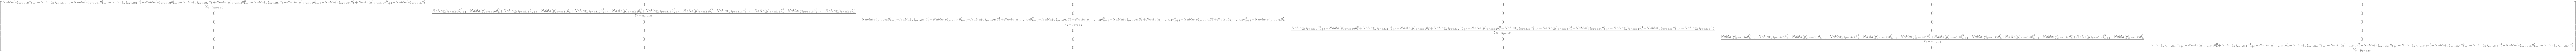

In [8]:
sys1 = M @ (Y-y_pred)
sys2 = nabla_y_pred.T @ (theta_k1-theta_k)
sys =sys1-sys2
p=solve(sys1-sys2, [M[k,k] for k in range(6)], manual=False)
for keys, values in p.items():
    M=M.replace(keys,values)
M

In [9]:
S = ((M @ (Y-y_pred))- sys2)
S.simplify()
S

In [10]:
## Fonction d'une itération en simulation

In [36]:
def compute_effort(A_list, Omega, R_list, v_B, v_W, cp_list, delta, takeoff, params_list):
   # Cl_list= [0,0,0,0,0]
   # Cd_list= [0,0,0,0,0]
    alpha_list=[0,0,0,0,0]
    #Force_wing_essai = np.array([0,0,0])
    #Torque_wing_essai = np.array([0,0,0])
    for p,cp in enumerate(cp_list) : 
        ###### Test du calcul de l'angle d'attaque et des efforts de chaque surface portante sue le drone #######
        VelinLDPlane = VelinLDPlane_function(Omega, cp, v_B, v_W, R_list[p].flatten())
        dragDirection = dragDirection_function(Omega, cp, v_B, v_W, R_list[p].flatten())
        liftDirection = liftDirection_function(Omega, cp, v_B, v_W, R_list[p].flatten())

        alpha = compute_alpha(dragDirection, liftDirection, np.array([1,0,0]), VelinLDPlane)
        alpha_list[p]=alpha
       # Cl_list[p] = Coeff_function(alpha, alpha_0_list[p], params_list[0], delta[p], params_list[9], params_list[5], params_list[3], params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4])[0]
       # Cd_list[p] = Coeff_function(alpha, alpha_0_list[p], params_list[0], delta[p], params_list[9], params_list[5], params_list[3], params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4])[1]
       # Force_wing_essai = Force_wing_essai+  Force_wing_function(A[p], Cd_list[p], Cl_list[p],v_B, v_W, Omega, cp, R_list[p].flatten()).flatten()
       # Torque_wing_essai = Torque_wing_essai+  Torque_wing_function(A[p], Cd_list[p], Cl_list[p], v_B, v_W, Omega, cp, R_list[p].flatten()).flatten()
    # Effort, Effort_T  = Effort_Aero_complete_function(A_list, Omega,  R_list[0].flatten(), v_B, v_W, cp_list, alpha_list, alpha_0_list, params_list[0], \
     #                                                  delta, params_list[9], params_list[5], params_list[3], params_list[7], params_list[8], params_list[6],\
     #                                                  params_list[1], params_list[2], params_list[4], ct, cq, ch, omega_rotor)
    
    Effort, Effort_T  =Effort_Aero_complete_function(A_list, Omega,  R_list[0].flatten(), v_B, v_W, cp_list,alpha_list, params_list["alpha0"], params_list['alpha_stall'], delta, params_list['largeur_stall'], params_list['CL_1_sa'], params_list['CD_1_fp'],params_list['k_0'],\
                                                     params_list['k_1'],params_list['k_2'],params_list['CD_0_fp'],params_list['CD_0_sa'],params_list['CD_1_sa'],params_list['Ct'],params_list['Cq'],params_list['ch'], params_list['omega_rotor'] )
    ##### Test des fonctions qui calcul la somme des forces des moteurs et des ailes ########
   # torque_somme1 = Sum_T_wing_function(Omega, R_list[0].flatten(), v_B, v_W, cp_list, Cd_list, Cl_list)     
   # force_somme1 = Sum_F_wing_function(Omega, R_list[0].flatten(), v_B, v_W, cp_list, Cd_list, Cl_list)

  #  Sum_F_rotor1 = Sum_F_rotor_function(Omega, R_list[0].flatten(), v_B, v_W, ct, cq, ch, omega_rotor)
    #Sum_Q_rotor1 = Sum_T_rotor_function(Omega, R_list[0].flatten(), v_B, v_W, ct, cq, ch, omega_rotor)

    ##### Test de la fonction qui regroupe tout le calcul précédent : Elle calcul les efforts des moteurs et des ailes #####
#    Effort, Effort_T = Effort_Aero_function(A_list, Omega,  R_list[0].flatten(), v_B, v_W, cp_list, Cd_list, Cl_list, ct, cq, ch, omega_rotor)
    Effort, Effort_T = R_list[0] @ np.transpose(Effort.flatten()) + masse*g,  Effort_T.flatten()
    if takeoff==0:
        Effort[2]=min(Effort[2],0)
    return  Effort, Effort_T

# Fonction gradient : 

In [37]:
def gradient_symbolique(Aire_list, Omega, R_list, v_B, v_W, cp_list, ct, cq, ch, omega_rotor, delta, alpha_0_list, takeoff, params_list):
    Cl_grad_list = [[0 for i in range(len(params_list))] for j in range(len(cp_list))]
    Cd_grad_list =  [[0 for i in range(len(params_list))] for j in range(len(cp_list))]
    alpha_list=[0,0,0,0,0]
    for p,cp in enumerate(cp_list) : 
        ###### Test du calcul de l'angle d'attaque et des efforts de chque surface portante sue le drone #######
        VelinLDPlane = VelinLDPlane_function(Omega, cp, v_B, v_W, R_list[p].flatten())
        dragDirection = dragDirection_function(Omega, cp, v_B, v_W, R_list[p].flatten())
        liftDirection = liftDirection_function(Omega, cp, v_B, v_W, R_list[p].flatten())

        alpha_list[p] = compute_alpha(dragDirection, liftDirection, np.array([1,0,0]), VelinLDPlane)
 #       Cl_grad_list[p] = grad_Cl_function(alpha, alpha_0_list[p], params_list[0], delta[p], params_list[9], params_list[5], params_list[3], \
 #                                          params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4]).flatten()
 #       Cd_grad_list[p] = grad_Cd_function(alpha, alpha_0_list[p], params_list[0], delta[p], params_list[9], params_list[5], params_list[3], \
 #                                          params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4]).flatten()
    
 #   Grad = Grad_Effort_Aero_function(Aire_list, Omega, R_list[0].flatten(), v_B, v_W, cp_list, Cd_grad_list, Cl_grad_list, Ct, Cq, ch, omega_rotor)
    GradF = Grad_Effort_Aero_complete_function(Aire_list, Omega, R_list[0].flatten(), v_B, v_W, cp_list, alpha_list, alpha_0_list, params_list[0], delta, params_list[9], params_list[5], params_list[3], \
                                                                       params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4], ct, cq, ch, omega_rotor)[0]
    GradT = Grad_Effort_Aero_complete_function(Aire_list, Omega, R_list[0].flatten(), v_B, v_W, cp_list, alpha_list, alpha_0_list, params_list[0], delta, params_list[9], params_list[5], params_list[3], \
                                                                       params_list[7], params_list[8], params_list[6], params_list[1], params_list[2], params_list[4], ct, cq, ch, omega_rotor)[1]
    
    for col in range(len(GradF)):
        GradF[:,col]= R @ np.array((GradF[0,col],GradF[1,col],GradF[2,col]))
        GradT[:,col]= R @ np.array((GradT[0,col],GradT[1,col],GradT[2,col]))
        if takeoff==0:
            GradF[:,col]=R @ np.array((GradF[0,col],GradF[1,col],0))
                        
    
    return GradF, GradT

def gradient_numerique(Aire_list, ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d, alpha_0_list, takeoff, params_list, eps, theta):
    grad=[0 for i in range(len(theta))]
    for k in range(len(theta)):
        params_list[k]=params_list[k]+eps
        f1, q1 = compute_effort(Aire_list, ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d, alpha_0_list, takeoff, params_list)
        params_list[k]=params_list[k]-2*eps
        f2, q2= compute_effort(Aire_list, ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d, alpha_0_list, takeoff, params_list)
        error1 = np.sum((f-f1)**2) + np.sum((q-q1)**2)
        error2 = np.sum((f-f2)**2) + np.sum((q-q2)**2)
        grad[k] =(error1 - error2)/(2*eps)

        params_list[k]=params_list[k]+eps
    return grad/np.linalg.norm(grad)

# Exportation des fonctions dans un fichier nomé : 

In [38]:
import dill as dill
dill.settings['recurse'] = True

Functions = [VelinLDPlane_function, \
             dragDirection_function, \
             liftDirection_function,\
             compute_alpha,\
             Effort_Aero_complete_function,\
             Grad_Effort_Aero_complete_function,\
             theta_list]
dill.dump(Functions, open("../Simulation/function_moteur_physique", "wb"))

In [112]:
g = np.array([0,0,9.81])
masse = 8.5

v_wind = np.array([0,0,0.0], dtype=np.float)
cp_list = [np.array([-0.013,0.475,-0.040],       dtype=np.float).flatten(), \
                                           np.array([-0.013,-0.475,-0.040],      dtype=np.float).flatten(), \
                                           np.array([-1.006,0.85,-0.134],    dtype=np.float).flatten(),\
                                           np.array([-1.006,-0.85,-0.134],   dtype=np.float).flatten(),\
                                           np.array([0.021,0,-0.064],          dtype=np.float).flatten()]
Aire_list = [0.62*0.262* 1.292 * 0.5, 0.62*0.262* 1.292 * 0.5, 0.34*0.01* 1.292 * 0.5, 0.34*0.1* 1.292 * 0.5, 1.08*0.31* 1.292 * 0.5]  # Liste des 1/2 * rho * S pour chaque surface

##################################################### Initialisation des coeffs prit pour le calul du gradient############
params_list = {"alpha0" : np.array([0.07,0.07,0,0,0.07]),\
               "alpha_stall" : 0.3391428111 ,                     \
               "largeur_stall" : 15.0*np.pi/180,                  \
               "CD_0_sa" : 0.045,\
               "CD_0_fp" : 0.045,\
               "CD_1_sa" : 4.55, \
               "CL_1_sa" : 5, \
               "CD_1_fp" : 2.5, \
               "k_0": 0.5, \
               "k_1": 0.5, \
               "k_2": 0.5,\
               "Ct": 1e-4, \
               "Cq": 1e-8, \
               "ch": 1e-4,\
               "omega_rotor":200}

    
    ##### Test des fonctions qui calcul la somme des forces des moteurs et des ailes ########
d =  [0.9765625,6.866455078125,0.9765625,10.7879638671875]
for q,i in enumerate(d):      # Ajout d'une zone morte dans les commandes 
            if abs(i)<250 :
                d[q] = 0
            elif q==0 or q==2 :
                d[q] = 0
            elif q==3 : 
                d[q] =d[q]/250 *  200
            else:
                d[q] = d[q] * 15 *np.pi/180 / 250 
omega_rotor = 200 + d[3]
d=np.array([d[0], -d[0], d[1]-d[2], d[1]+d[2], 0])


q = tf3d.quaternions.axangle2quat([0, 1, 0], 0.07)
v= np.array([11.5,0,0])
ome = [0,0,0]
takeoff=1
R = tf3d.quaternions.quat2mat(q)
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)
r = np.array(((1,0, 0),(0,c45,-s45),(0,s45, c45)))
r_neg     = np.array(((1,0, 0), (0,c45, s45),(0,-s45, c45)))
R_list = [R, R,  R @ r,  R @r_neg, R] 


In [113]:
compute_effort(Aire_list,ome, R_list, v, v_wind, cp_list,d, takeoff, params_list)

(array([ 1.23646954e-01, -5.55111512e-16,  4.28525035e+01]),
 array([ 1.24900090e-16, -5.55287222e-01,  4.99600361e-16]))

# Test des fonctions sur une itération

In [14]:
cp_list = [np.array([0,0.45,0], dtype=np.float), np.array([0,-0.45,0], dtype=np.float), \
           np.array([-0.5,0.15,0], dtype=np.float), np.array([-0.5,-0.15,0], dtype=np.float),np.array([0,0,0], dtype=np.float)]
g = np.array([0,0,9.81])
masse = 2.5
ct = 2.5e-5
cq=1e-8
ch=1e-4
v_wind = np.array([0,0,0.0], dtype=np.float)
cp_list =[np.array([0,0.45,0],       dtype=np.float).flatten(), \
                                           np.array([0,-0.45,0],      dtype=np.float).flatten(), \
                                           np.array([-0.5,0.15,0],    dtype=np.float).flatten(),\
                                           np.array([-0.5,-0.15,0],   dtype=np.float).flatten(),\
                                           np.array([0,0,0],          dtype=np.float).flatten()]
alpha_0_list    =  np.array([0.06,0.06,0,0,0.06])
alpha0 = 0.06
alpha_0_list = np.array([alpha0,alpha0,0.0,0.0,alpha0])
Aire_list = [0.03* 1.292 * 0.5, 0.03* 1.292 * 0.5, 0.01* 1.292 * 0.5, 0.01* 1.292 * 0.5, 0.04* 1.292 * 0.5]  # Liste des 1/2 * rho * S pour chaque surface

##################################################### Initialisation des coeffs prit pour le calul du gradient############
## !!!!!!!! Attention : Il faut mettre les mêmes paramètres que lors de la générations des équations dans le premiers bloc! !!!!!!!!!!
Theta={ "cd0sa" : 0.045,\
       "cd1sa" : 4.55, \
       "cl1sa" : 5, \
       "coeff_drag_shift": 0.5, \
       "coeff_lift_shift": 0.5, \
       "coef_lift_gain": 0.5}
Theta = OrderedDict(sorted(Theta.items(), key=lambda t: t[0]))
params_list = [i for i in Theta.values()]
d =  [0.9765625,6.866455078125,0.9765625,10.7879638671875]
for q,i in enumerate(d):      # Ajout d'une zone morte dans les commandes 
            if abs(i)<250 :
                d[q] = 0
            elif q==0 or q==2 :
                d[q] = 0
            elif q==3 : 
                d[q] =d[q]/250 *  200
            else:
                d[q] = d[q] * 15 *np.pi/180 / 250 
omega_rotor = 200 + d[3]
d=np.array([d[0], -d[0], d[1]-d[2], d[1]+d[2], 0])

q = [0.9393771503552618,4.365255638259018e-14,-0.34288565060443704,-4.470521183381739e-13]
v= np.array([29.010076134793344,-4.975607323921865e-11,24.342341031470887])
ome = [-1.808814642571909e-12,0.08219516150237959,7.857520916486095e-12]
takeoff=1
R = tf3d.quaternions.quat2mat(q)
c45, s45 = np.cos(45*np.pi/180), np.sin(45*np.pi/180)
r = np.array(((1,0, 0),(0,c45,-s45),(0,s45, c45)))
r_neg     = np.array(((1,0, 0), (0,c45, s45),(0,-s45, c45)))
R_list = [R, R,  R @ r,  R @r_neg, R] 

#################################################### Test des fonctions dans le cas d'une seul itérations, sans compter la dynamique (masse, inertie) du drone ####################################################


f, q = np.array([13.873565, -1.708429e-12 , 1.103913]), np.array([8.850101e-12  ,0.006502, -7.302492e-13])
gradF = gradient_symbolique(Aire_list, ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d,alpha_0_list, takeoff, params_list)
grad_sympy = (-2 * (np.r_[f,q]- np.r_[compute_effort(Aire_list,ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d, alpha_0_list, takeoff, params_list)]))@np.r_[gradF[0], gradF[1]]
if not np.linalg.norm(grad_sympy)==0:
    grad_sympy/=np.linalg.norm(grad_sympy)

eps=1e-12
grad = gradient_numerique(Aire_list, ome, R_list, v, v_wind, cp_list, ct, cq, ch, omega_rotor,d, alpha_0_list, takeoff, params_list, eps, Theta)

print(grad_sympy@grad)

IndexError: list index out of range